In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import pickle

print("TensorFlow Version:", tf.__version__)


2025-07-10 10:58:50.382270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752145130.640346      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752145130.719842      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE_PER_REPLICA = 32
SEED = 42
DATA_DIR = '/kaggle/input/data'

In [3]:
# --- TPU/GPU Strategy ---
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU')
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
    print('Running on GPU(s)')

print("REPLICAS: ", strategy.num_replicas_in_sync)
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Effective batch size: {BATCH_SIZE}")

Running on GPU(s)
REPLICAS:  1
Effective batch size: 32


2025-07-10 10:59:06.945824: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Load metadata
try:
    df = pd.read_csv(os.path.join(DATA_DIR, 'Data_Entry_2017.csv'))
    print("Metadata loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'Data_Entry_2017.csv' not found in '{DATA_DIR}'.")
    exit()

# Create image paths and drop missing ones
all_image_paths = {os.path.basename(p): p for p in glob.glob(os.path.join(DATA_DIR, '**', '*.png'), recursive=True)}
df['path'] = df['Image Index'].map(all_image_paths.get)
df = df.dropna(subset=['path'])
print(f"Found {len(df)} images with corresponding metadata.")

Metadata loaded successfully.
Found 112120 images with corresponding metadata.


In [5]:
# One-hot encode labels
all_labels = np.unique(list(chain.from_iterable(df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [label for label in all_labels if label != 'No Finding']
for label in all_labels:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

# Split data into train, validation, and test sets by patient ID
patient_ids = df['Patient ID'].unique()
train_val_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=SEED)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.1, random_state=SEED)

train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]

In [6]:
# --- Data Augmentation and tf.data Pipelines ---
data_augmentation_pipeline = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
], name="data_augmentation")

def parse_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image, label

def create_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'].values, df[all_labels].values))
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)
print("tf.data pipelines created successfully.")

tf.data pipelines created successfully.


In [7]:
with strategy.scope():
    base_model = EfficientNetB0(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights=None 
    )
    base_model.trainable = False 

    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = data_augmentation_pipeline(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(all_labels), activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    try:
        model.load_weights('/kaggle/input/efficient-net-nih-model-training/initial_training_weights.weights.h5')
        print("Successfully loaded weights from initial training.")
    except (IOError, tf.errors.NotFoundError):
        print("Could not find 'initial_training_weights.weights.h5'.")
        print("Please ensure the initial training was completed and the weights file is available.")
        exit()


Successfully loaded weights from initial training.


In [8]:
# Set the base model to be trainable
base_model.trainable = True

# Calculate the number of layers to unfreeze (top 40%)
total_layers = len(base_model.layers)
unfreeze_layers = int(total_layers * 0.40)

print(f"Total layers in base model: {total_layers}")
print(f"Unfreezing the top {unfreeze_layers} layers for fine-tuning.")

Total layers in base model: 237
Unfreezing the top 94 layers for fine-tuning.


In [9]:
# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False
# Unfreeze the top layers
for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

In [10]:
# --- Re-compile the Model for Fine-Tuning ---
with strategy.scope():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate
        loss=tf.keras.losses.BinaryCrossentropy(), # Can continue with the same loss
        metrics=[tf.keras.metrics.AUC(name='auc_roc', multi_label=True)]
    )

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,067,505 (15.52 MB)

 Trainable params: 3,457,734 (13.19 MB)

 Non-trainable params: 609,771 (2.33 MB)

In [11]:
print("\nStarting fine-tuning...")

fine_tune_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fine_tuning_weights.weights.h5',
    save_weights_only=True,
    monitor='val_auc_roc',
    mode='max',
    save_best_only=True
)

fine_tune_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc_roc', 
    patience=5,
    mode='max', 
    restore_best_weights=True
)

history_fine_tune = None
try:
    history_fine_tune = model.fit(
        train_ds,
        epochs=5,
        validation_data=val_ds,
        callbacks=[fine_tune_checkpoint, fine_tune_early_stopping]
    )
    print("Fine-tuning complete.")
except Exception as e:
    print(f"An error occurred during model training: {e}")




Starting fine-tuning...
Epoch 1/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 7020s 3s/step - auc_roc: 0.5654 - loss: 0.3078 - val_auc_roc: 0.6707 - val_loss: 0.1750
Epoch 2/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 7099s 3s/step - auc_roc: 0.6531 - loss: 0.1709 - val_auc_roc: 0.7071 - val_loss: 0.1721
Epoch 3/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 6958s 3s/step - auc_roc: 0.6886 - loss: 0.1658 - val_auc_roc: 0.7232 - val_loss: 0.1696
Epoch 4/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 6992s 3s/step - auc_roc: 0.7040 - loss: 0.1630 - val_auc_roc: 0.7311 - val_loss: 0.1680
Epoch 5/5
2521/2521 ━━━━━━━━━━━━━━━━━━━━ 6964s 3s/step - auc_roc: 0.7233 - loss: 0.1604 - val_auc_roc: 0.7362 - val_loss: 0.1681
Fine-tuning complete.


Plotting and saving fine-tuning history...


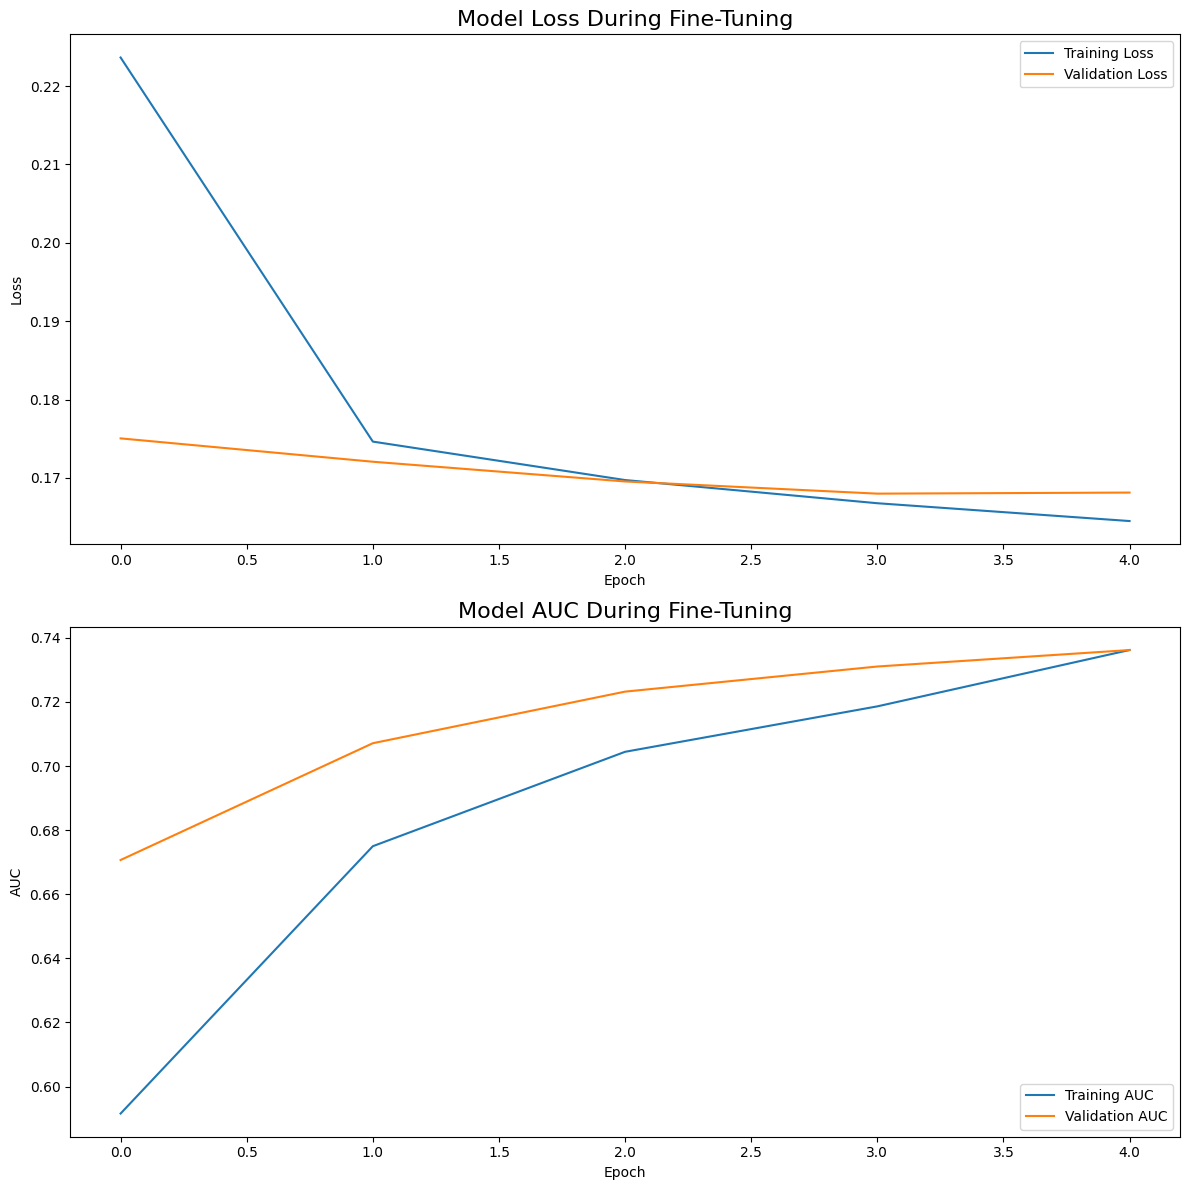

History plot generated and history data saved to 'fine_tuning_history.csv' and 'history_fine_tune.pkl'.


In [12]:
if history_fine_tune:
    print("Plotting and saving fine-tuning history...")

    def plot_training_history(history):
        """Plots training and validation loss and AUC."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

        # Plot Loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss During Fine-Tuning', fontsize=16)
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc='upper right')

        # Plot AUC
        ax2.plot(history.history['auc_roc'], label='Training AUC')
        ax2.plot(history.history['val_auc_roc'], label='Validation AUC')
        ax2.set_title('Model AUC During Fine-Tuning', fontsize=16)
        ax2.set_ylabel('AUC')
        ax2.set_xlabel('Epoch')
        ax2.legend(loc='lower right')

        plt.tight_layout()
        plt.show()

    # Plot the history from the fine-tuning phase
    plot_training_history(history_fine_tune)

    # Save the history object for later analysis
    history_df = pd.DataFrame(history_fine_tune.history)
    history_df.to_csv('fine_tuning_history.csv', index=False)

    # Alternatively, save the full history object using pickle
    with open('history_fine_tune.pkl', 'wb') as file_pi:
        pickle.dump(history_fine_tune.history, file_pi)

    print("History plot generated and history data saved to 'fine_tuning_history.csv' and 'history_fine_tune.pkl'.")
else:
    print("Skipping history plotting and saving because training did not complete successfully.")
